# Air Quality Forecasting: Time Series Assignment

## Introduction

Air pollution, especially PM2.5, is a major concern for public health and urban planning. Accurate forecasting of PM2.5 concentrations enables timely interventions to reduce health risks. In this assignment, I use historical air quality and weather data from Beijing to predict future PM2.5 levels using Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models. The goal is to preprocess the data, design and train a deep learning model, and generate predictions for submission to a Kaggle competition.

## Data Exploration

I begin by loading and inspecting the training and test datasets. This step helps me understand the data structure, identify missing values, and plan preprocessing steps. I will also visualize the distribution of the target variable (pm2.5) and extract useful time-based features.

In [80]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load the datasets from the local data folder
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Display the first few rows of the training data
train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [81]:
# Check for missing values in the training data
missing_values = train.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Show summary statistics
train.describe()

Missing values in each column:
 No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


In [82]:
# Convert 'datetime' column to datetime type
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set 'datetime' as index for time series analysis
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# Fill missing pm2.5 values by interpolation, then with mean for any remaining
train['pm2.5'] = train['pm2.5'].interpolate().fillna(train['pm2.5'].mean())

# Fill any missing values in test set by interpolation
for col in test.columns:
    if test[col].isnull().any():
        test[col] = test[col].interpolate().fillna(test[col].mean())

# Confirm missing values are handled
print("Missing values after cleaning:\n", train.isnull().sum())

Missing values after cleaning:
 No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
pm2.5      0
dtype: int64


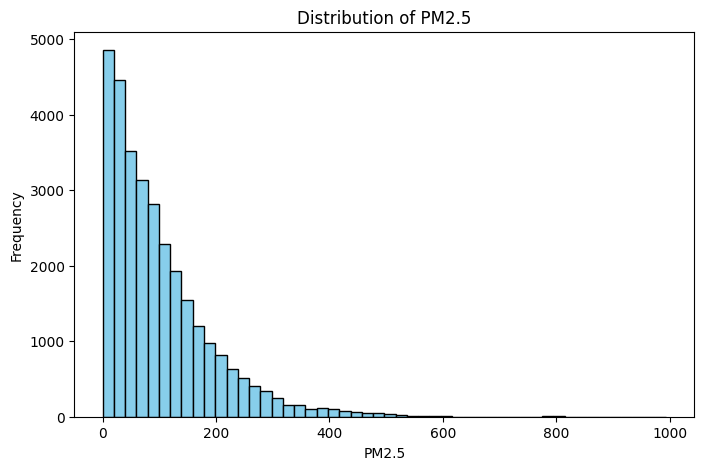

In [83]:
# Visualize the distribution of pm2.5
plt.figure(figsize=(8,5))
plt.hist(train['pm2.5'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of PM2.5')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.show()

In [84]:
# Extract time-based features for further analysis
train['year'] = train.index.year
train['month'] = train.index.month
train['week'] = train.index.isocalendar().week
train['day_of_year'] = train.index.dayofyear
train['hour'] = train.index.hour
train['day'] = train.index.dayofweek
train['day_str'] = train.index.strftime('%a')
train['year_month'] = train.index.strftime('%Y_%m')

# Show updated training data
train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,year,month,week,day_of_year,hour,day,day_str,year_month
datetime,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,0,4,Fri,2010_01
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,1,4,Fri,2010_01
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,2,4,Fri,2010_01
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,3,4,Fri,2010_01
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,4,4,Fri,2010_01


In [85]:
# Test TensorFlow installation and version
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.13.0


## Model Design

In this section, I prepare the data for time series modeling and build an LSTM model to forecast PM2.5. I use a sequence-to-one approach, where the model learns to predict the next PM2.5 value based on a window of previous time steps and features.

In [86]:
# Select features for modeling
features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv',
            'year', 'month', 'week', 'day_of_year', 'hour', 'day']

# Prepare sequences for LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features + ['pm2.5']])

# Define sequence length (number of previous time steps to use)
SEQ_LEN = 24  
X, y = [], []
for i in range(SEQ_LEN, len(train_scaled)):
    X.append(train_scaled[i-SEQ_LEN:i, :-1])  
    y.append(train_scaled[i, -1])  
X, y = np.array(X), np.array(y)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (24521, 24, 15)
y_train shape: (24521,)


In [87]:
# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                20480     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                20480     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                

In [88]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=2
)

Epoch 1/10
384/384 - 11s - loss: 0.0047 - root_mean_squared_error: 0.0682 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0803 - 11s/epoch - 28ms/step
Epoch 2/10
384/384 - 11s - loss: 0.0047 - root_mean_squared_error: 0.0682 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0803 - 11s/epoch - 28ms/step
Epoch 2/10
384/384 - 6s - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859 - 6s/epoch - 16ms/step
Epoch 3/10
384/384 - 6s - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859 - 6s/epoch - 16ms/step
Epoch 3/10
384/384 - 6s - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844 - 6s/epoch - 17ms/step
Epoch 4/10
384/384 - 6s - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844 - 6s/epoch - 17ms/step
Epoch 4/10
384/384 - 7s - loss: 0.0032 - root_mean_squared_error: 0.0566 - val

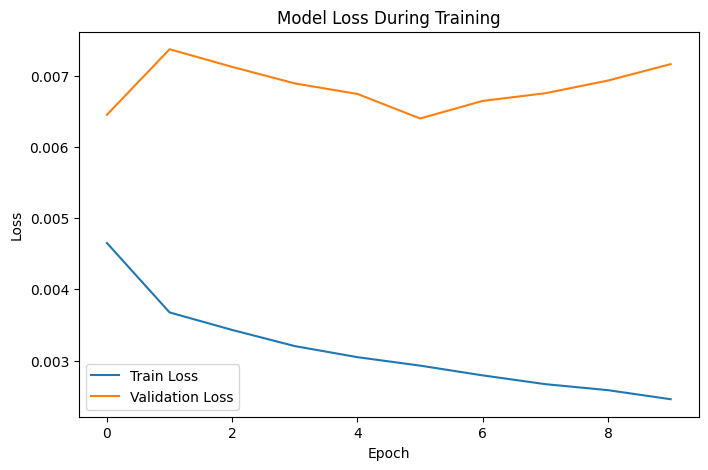

In [89]:
# Plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prediction and Submission

Now I use the trained LSTM model to predict PM2.5 values for the test set and prepare the submission file for Kaggle. The predictions are inverse-transformed to the original scale and saved in the required format.

In [90]:

# Extract time-based features for the test set (must match train)
test['year'] = test.index.year
test['month'] = test.index.month
test['week'] = test.index.isocalendar().week
test['day_of_year'] = test.index.dayofyear
test['hour'] = test.index.hour
test['day'] = test.index.dayofweek

In [92]:
# Prepare test data for prediction

X_test = []
test_features = test[features].copy()
test_features['pm2.5'] = 0  
test_scaled = scaler.transform(test_features)


for i in range(len(test_scaled)):
    if i < SEQ_LEN:
        pad = np.zeros((SEQ_LEN - i, test_scaled.shape[1] - 1))  
        seq = np.vstack([pad, test_scaled[:i, :-1]])
    else:
        seq = test_scaled[i-SEQ_LEN:i, :-1]
    X_test.append(seq)
X_test = np.array(X_test)

print('X_test shape:', X_test.shape)

X_test shape: (13148, 24, 15)


In [93]:
# Predict pm2.5 for the test set
pred_scaled = model.predict(X_test)

full_pred = np.zeros((len(pred_scaled), len(features) + 1))
full_pred[:, :-1] = test_scaled[:, :-1]  
full_pred[:, -1] = pred_scaled.flatten()  
pred_pm25 = scaler.inverse_transform(full_pred)[:, -1]

# Show a few predictions
print(pred_pm25[:10])

411/411 [==============================] - 3s 5ms/step
[ 57.80449276  93.96788689 108.19762065 110.37409684  99.38307905
  84.21148807  72.76022464  57.85019813  43.45474306  26.86417677]
[ 57.80449276  93.96788689 108.19762065 110.37409684  99.38307905
  84.21148807  72.76022464  57.85019813  43.45474306  26.86417677]


In [94]:
# Prepare submission file
sample_submission = pd.read_csv('sample_submission .csv')
sample_submission['pm2.5'] = pred_pm25
submission_path = 'submission.csv'
sample_submission.to_csv(submission_path, index=False)
print(f'Submission file saved as {submission_path}')

Submission file saved as submission.csv
